In [1]:
import numpy as np
import seaborn as sns
import sys
# sys.path.insert(0, './src')

# from trajectory import trajectory
# from kf import KF
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn

sns.set()

In [2]:
# %load_ext autoreload
# %autoreload 2

# Class Definition

In [3]:
class trajectory():

    def __init__(self,
                 A,
                 H,
                 Q,
                 R,
                 init_state,
                 B=None,
                 u=None,
                 random_state=None,
                 n=100):

        # Simulation parameters
        self.n = n
        self.seed = random_state

        # Process model
        self.A = A
        self.B = B
        self.u = u
        self.Q = Q
        self.x0 = init_state

        # Measurement model
        self.H = H
        self.R = R

        # Store actual state & measurements
        self.X = np.zeros(shape=(self.A.shape[0], self.n))
        self.Y = np.zeros(shape=(self.H.shape[0], self.n))

        # Simulate the trajectory
        self._simulate()

    def _simulate(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        x = self.x0
        for t in range(self.n):
            x = self.A @ x + mvn.rvs(cov=self.Q)
            if self.B is not None and self.u is not None:
                x += self.B @ self.u

            y = self.H @ x + mvn.rvs(cov=self.R)

            self.X[:, t] = x.flatten()
            self.Y[:, t] = y.flatten()

In [4]:
class KF():
    def __init__(self, A, B, H, R, Q):
        self.A = A
        self.B = B
#        self.H = H
        self.H = np.atleast_2d(H)
        self.Q = Q
        self.P = np.eye(A.shape[0]) * 1000.
        self.x = np.zeros(A.shape[0])
        self.log_x = []
        self.xi = np.zeros(np.asarray(self.P.shape) + 1)
        if np.isscalar(R):
            self.Rinv = 1/R
        else:
            self.Rinv = np.linalg.inv(R)

    def predict(self, u=None):
        xminus = self.A.dot(self.x)
        if u is not None:
            xminus += self.B.dot(u)
        Pminus = self.A.dot(self.P).dot(self.A.T) + self.Q
        xi_vector = np.r_[xminus[np.newaxis], np.eye(self.x.shape[0])]
        self.xi = xi_vector.dot(np.linalg.inv(Pminus)).dot(xi_vector.T)
        self.x = xminus   # temporary
        self.P = Pminus   # temporary

    def update(self, y, Rinv=None):
        if Rinv is None:
            Rinv = self.Rinv
        y = np.atleast_2d(y).reshape(self.H.shape[0], -1)
        T_vector = np.concatenate((y, self.H), axis=1)
        T = T_vector.T.dot(Rinv).dot(T_vector)
        self.xi += T
        self.P = np.linalg.inv(self.xi[1:, 1:])
        self.x = self.P.dot(self.xi[1:, 0])

    def log(self):
        self.log_x.append(self.x.copy())

# Simulate CAM trajectory

In [5]:
ndat = 100
dt = 1
q_tr = 0.5
r_tr = 50

init_state = np.array([0, 0, 1, -1, -0.1, 0.1])

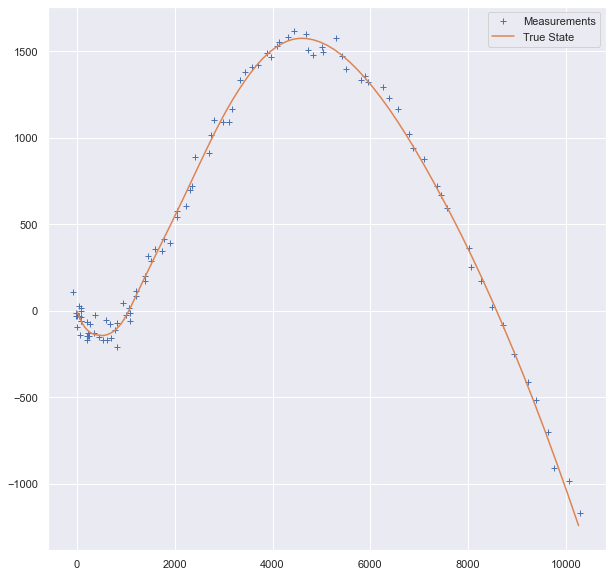

In [6]:
# Transition matrix
A_tr = np.array([
    [1, 0, dt,  0, dt**2/2,       0],
    [0, 1, 0,  dt,       0, dt**2/2],
    [0, 0, 1,   0,      dt,       0],
    [0, 0, 0,   1,       0,      dt],
    [0, 0, 0,   0,       1,       0],
    [0, 0, 0,   0,       0,       1]
])

# Process noise
Q_tr = q_tr * np.array([
    [dt**5/20,        0, dt**4/8,       0, dt**3/6,       0],
    [       0, dt**5/20,       0, dt**4/8,       0, dt**3/6],
    [ dt**4/8,        0, dt**3/3,       0, dt**2/2,       0],
    [       0,  dt**4/8,       0, dt**3/3,       0, dt**2/2],
    [ dt**3/6,        0, dt**2/2,       0,      dt,       0],
    [       0,  dt**3/6,       0, dt**2/2,       0,      dt]
    
])

H_tr = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0]])
R_tr = r_tr**2 * np.eye(2)

traj = trajectory(A_tr, H_tr, Q_tr, R_tr, init_state, random_state=563, n=ndat)

# Plot trajectory
plt.figure(figsize=(10, 10))
# plt.axis("equal")
plt.plot(traj.Y[0,:], traj.Y[1,:], "+", label="Measurements")
plt.plot(traj.X[0,:], traj.X[1,:], label="True State")
plt.legend()
plt.show()

# Trajectory estimation using Kalman Filter

In [7]:
dt = 1

# True Q and R
# q_m = q_tr
# r_m = r_tr

q_m = 5
r_m = 100

## Model Initialization

In [8]:
# Random Walk Model
A_rwm = np.array([[1, 0],
                  [0, 1]])

Q_rwm = q_m * np.array([[dt, 0],
                        [0, dt]])

H_rwm = np.array([[1, 0],
                  [0, 1]])

R_rwm = r_m**2 * np.eye(2)

kf_rwm = KF(A=A_rwm, B=None, H=H_rwm, R=R_rwm, Q=Q_rwm)
# ===================================================================================
# Constant Velocity Model
A_cvm = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1,  0],
                  [0, 0, 0,  1]])

Q_cvm = q_m * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                        [0,       dt**3/3, 0,       dt**2/2],
                        [dt**2/2, 0,       dt,      0      ],
                        [0,       dt**2/2, 0,       dt     ]])

H_cvm = np.array([[1., 0, 0, 0],
                  [0., 1, 0, 0]])
R_cvm = r_m**2 * np.eye(2)

kf_cvm = KF(A=A_cvm, B=None, H=H_cvm, R=R_cvm, Q=Q_cvm)
# ===================================================================================
# Constant Acceleration Model
A_cam = np.array([
    [1, 0, dt,  0, dt**2/2,       0],
    [0, 1, 0,  dt,       0, dt**2/2],
    [0, 0, 1,   0,      dt,       0],
    [0, 0, 0,   1,       0,      dt],
    [0, 0, 0,   0,       1,       0],
    [0, 0, 0,   0,       0,       1]
])

Q_cam = q_m * np.array([
    [dt**5/20,        0, dt**4/8,       0, dt**3/6,       0],
    [       0, dt**5/20,       0, dt**4/8,       0, dt**3/6],
    [ dt**4/8,        0, dt**3/3,       0, dt**2/2,       0],
    [       0,  dt**4/8,       0, dt**3/3,       0, dt**2/2],
    [ dt**3/6,        0, dt**2/2,       0,      dt,       0],
    [       0,  dt**3/6,       0, dt**2/2,       0,      dt]
    
])

H_cam = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0]])
R_cam = r_m**2 * np.eye(2)

kf_cam = KF(A=A_cam, B=None, H=H_cam, R=R_cam, Q=Q_cam)

In [9]:
for yt in traj.Y.T:
    kf_rwm.predict()
    kf_rwm.update(yt)
    kf_rwm.log()
    
    kf_cvm.predict()
    kf_cvm.update(yt)
    kf_cvm.log()
    
    kf_cam.predict()
    kf_cam.update(yt)
    kf_cam.log()
    
log_rwm = np.array(kf_rwm.log_x)
log_cvm = np.array(kf_cvm.log_x)
log_cam = np.array(kf_cam.log_x)

# Plotting the  Results

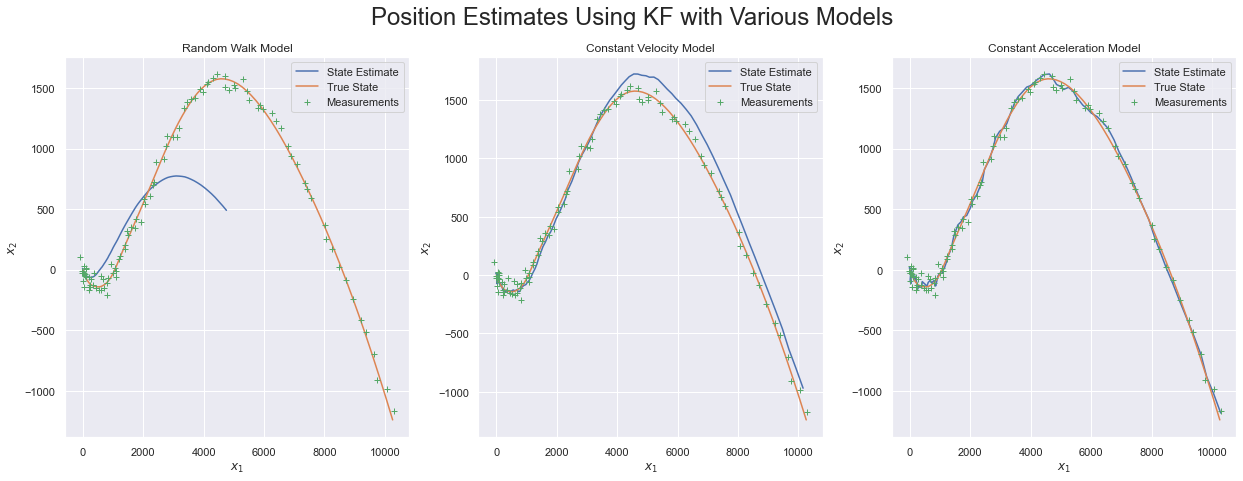

In [10]:
plt.figure(figsize=(21, 7))
plt.suptitle("Position Estimates Using KF with Various Models", fontsize=24)

plt.subplot(1, 3, 1)
plt.plot(log_rwm[:, 0], log_rwm[:, 1], label="State Estimate")
plt.plot(traj.X[0, :], traj.X[1, :], label="True State")
plt.plot(traj.Y[0, :], traj.Y[1, :], '+', label="Measurements")
plt.title("Random Walk Model")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(log_cvm[:, 0], log_cvm[:, 1], label="State Estimate")
plt.plot(traj.X[0, :], traj.X[1, :], label="True State")
plt.plot(traj.Y[0, :], traj.Y[1, :], '+', label="Measurements")
plt.title("Constant Velocity Model")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(log_cam[:, 0], log_cam[:, 1], label="State Estimate")
plt.plot(traj.X[0, :], traj.X[1, :], label="True State")
plt.plot(traj.Y[0, :], traj.Y[1, :], '+', label="Measurements")
plt.title("Constant Acceleration Model")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()

plt.show()

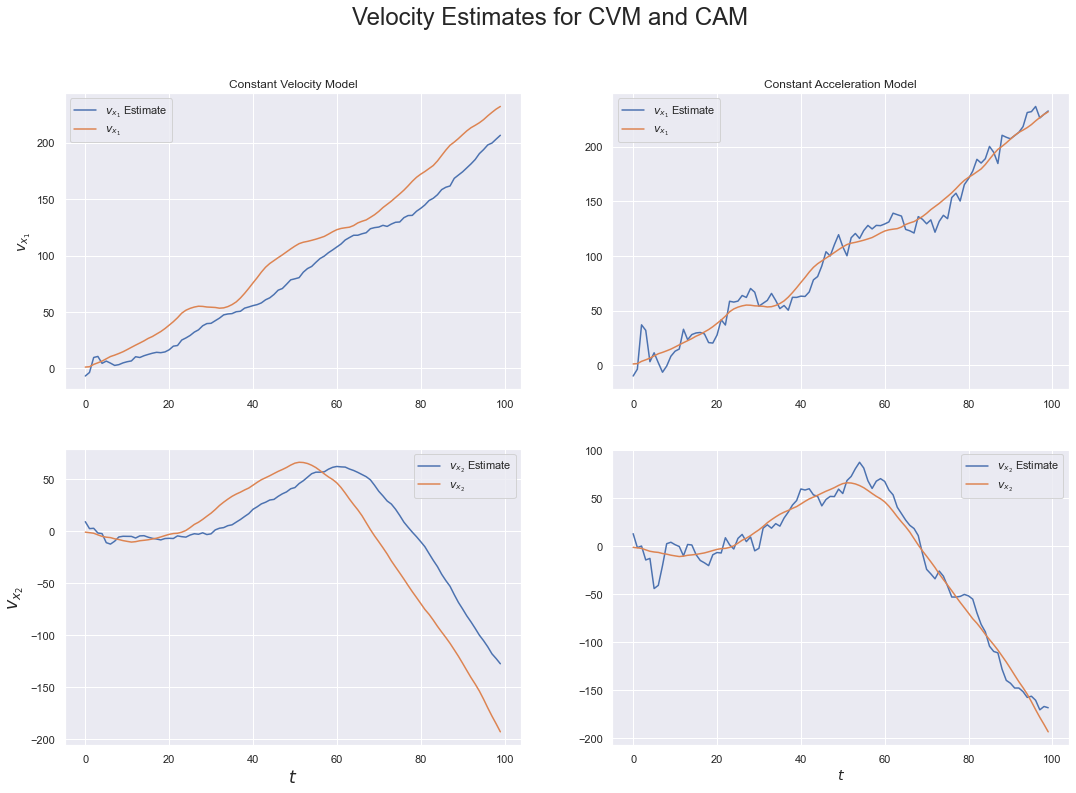

In [11]:
plt.figure(figsize=(18, 12))
plt.suptitle("Velocity Estimates for CVM and CAM", fontsize=24)

plt.subplot(2, 2, 1)
plt.plot(log_cvm[:, 2], label="$v_{x_1}$ Estimate")
plt.plot(traj.X[2, :], label="$v_{x_1}$")
plt.title("Constant Velocity Model")
plt.ylabel("$v_{x_1}$", fontsize="large")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(log_cam[:, 2], label="$v_{x_1}$ Estimate")
plt.plot(traj.X[2, :], label="$v_{x_1}$")
plt.title("Constant Acceleration Model")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(log_cvm[:, 3], label="$v_{x_2}$ Estimate")
plt.plot(traj.X[3, :], label="$v_{x_2}$")
plt.xlabel("$t$", fontsize="x-large")
plt.ylabel("$v_{x_2}$", fontsize="x-large")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(log_cam[:, 3], label="$v_{x_2}$ Estimate")
plt.plot(traj.X[3, :], label="$v_{x_2}$")
plt.xlabel("$t$", fontsize="large")
plt.legend()

plt.show()

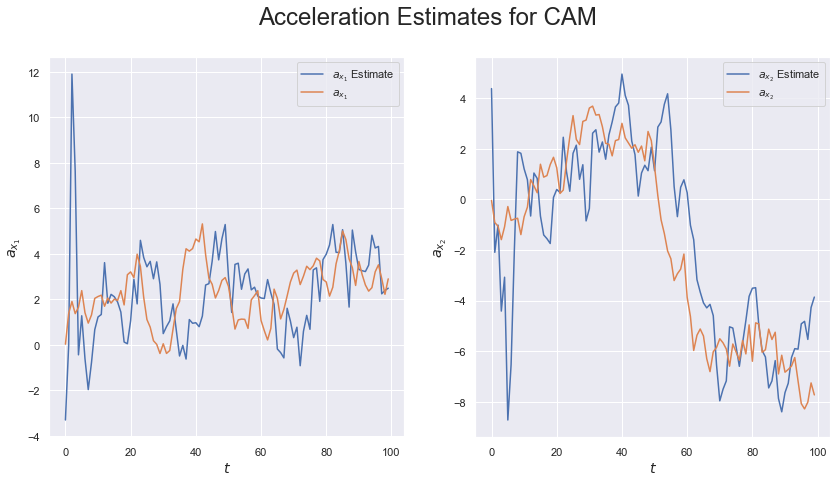

In [12]:
plt.figure(figsize=(14, 7))
plt.suptitle("Acceleration Estimates for CAM", fontsize=24)

plt.subplot(1, 2, 1)
plt.plot(log_cam[:, 4], label="$a_{x_1}$ Estimate")
plt.plot(traj.X[4, :], label="$a_{x_1}$")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("$a_{x_1}$", fontsize="large")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_cam[:, 5], label="$a_{x_2}$ Estimate")
plt.plot(traj.X[5, :], label="$a_{x_2}$")
plt.xlabel("$t$", fontsize="large")
plt.ylabel("$a_{x_2}$", fontsize="large")
plt.legend()

plt.show()